In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!pip install -q keras

In [3]:
import pandas as pd
import numpy as np 
import keras
import matplotlib.pyplot as plt
import pickle

Using TensorFlow backend.


In [0]:
features = pd.read_csv("/content/drive/My Drive/Deep learning/features.csv")
dam_prices = pd.read_csv("/content/drive/My Drive/Deep learning/dam_prices.csv")
rt_prices = pd.read_csv("/content/drive/My Drive/Deep learning/rt_prices.csv")

In [5]:
features.tail()

,dates,Gas.price,MidAtl_Pool_pr,western_Pool_prev,Total_Pool_prev,Percent.diff.MidAtl_Pool_pr,Percent.diff.western_Pool_prev,Percent.diff.Total_Pool_prev,PJM.POOL.J2,MISO_POOL_J2
16866,12/31/2019 20:00,1.935,34347.0,49546.0,95946.0,-0.011326,-0.022184,-0.015921,2116.0,6831.0
16867,12/31/2019 21:00,1.935,33626.0,49371.0,94931.0,-0.020983,-0.003520,-0.010579,2134.0,6542.0
16868,12/31/2019 22:00,1.935,32335.0,48197.0,92016.0,-0.038397,-0.023783,-0.030706,2152.0,6280.0
16869,12/31/2019 23:00,1.935,30628.0,46563.0,88286.0,-0.052795,-0.033892,-0.040536,2171.0,6017.0
16870,1/1/2020 0:00,1.935,28749.0,44143.0,83660.0,-0.061357,-0.051993,-0.052396,2189.0,5754.0


#Data preparation

Since we will try to fit a LSTM, the prices we want to predict make part of the features that help us predict the target vaariable. I will fit one model per price (for a total of 6 models), so, I will have 6 differents data sets. 

In [6]:
print(dam_prices.columns)

Index(['dates', 'SMECO_RESID_AGG..DALMP..Average',
       'DOM_RESID_AGG..DALMP..Average', 'AEPKY_RESID_AGG..DALMP..Average'],
      dtype='object')


In [0]:
SMECO_RESID_AGG_dam = pd.concat([features, dam_prices["SMECO_RESID_AGG..DALMP..Average"]], axis = 1)
SMECO_RESID_AGG_rt = pd.concat([features, rt_prices["SMECO_RESID_AGG..RTLMP..Average"]], axis = 1)

DOM_RESID_AGG_dam = pd.concat([features, dam_prices["DOM_RESID_AGG..DALMP..Average"]], axis = 1)
DOM_RESID_AGG_rt = pd.concat([features, rt_prices["DOM_RESID_AGG..RTLMP..Average"]], axis = 1)

AEPKY_RESID_AGG_dam = pd.concat([features, dam_prices["AEPKY_RESID_AGG..DALMP..Average"]], axis = 1)
AEPKY_RESID_AGG_rt = pd.concat([features, rt_prices["AEPKY_RESID_AGG..RTLMP..Average"]], axis = 1)

## Partial autocorrelation analysis

We need to figure out how to shape the matrix. We need batch size, time steps and features. Batch size will be 24 for a 24h weight update, features are the features we have avalaible (11) and time steps we have to figure out. A autocorrelation analysis will help us figure out how many time steps we should get. 

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


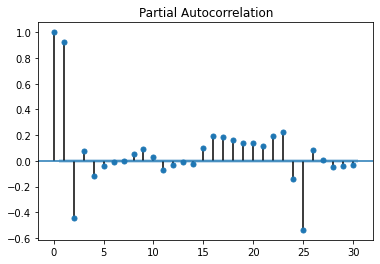

In [8]:
plot_pacf(dam_prices["SMECO_RESID_AGG..DALMP..Average"], lags=30)
pyplot.show()

Here we see that for this node, the partial autocorrelation is more or less significative for the first 25 lags

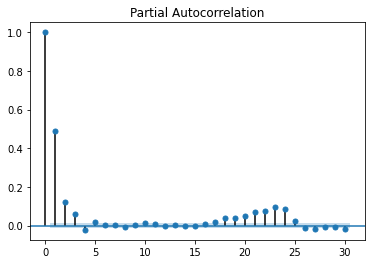

In [9]:
plot_pacf(rt_prices["SMECO_RESID_AGG..RTLMP..Average"], lags=30)
pyplot.show()

Here, we can see that the partial autocorrelation stays significaitve for the first 4 lags. 

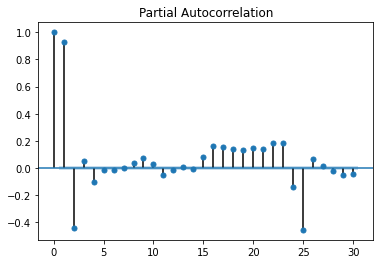

In [10]:
plot_pacf(dam_prices["DOM_RESID_AGG..DALMP..Average"], lags=30)
pyplot.show()

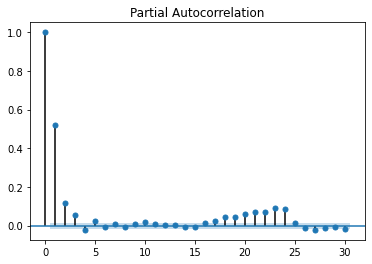

In [11]:
plot_pacf(rt_prices["DOM_RESID_AGG..RTLMP..Average"], lags=30)
pyplot.show()

So the time steps composant of the input matrix will be 25 for the dam models and 4 for the real time models

## Normalizing the data and creating test and train sets.

There are two ways to normalize the data, with MaxMinScaler and StandardScaler. Serveral exemples I found on the internet use the MinMaxScaler, I have tendency to use the StandardScaler and a tanh function in the first layer, so I avoid compressing my outliers. 

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [31]:
print(SMECO_RESID_AGG_dam.columns[10])

SMECO_RESID_AGG..DALMP..Average


In [0]:
def Split_and_Norm(df):
  
  df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
  # scale the feature MinMax, build array
  train_cols = df.columns[1:len(df.columns)]
  x = df_train.loc[:,train_cols].values
  MinMax_scaler = MinMaxScaler()
  x_train = MinMax_scaler.fit_transform(x)
  x_test = MinMax_scaler.transform(df_test.loc[:,train_cols])

  return(x_train, x_test,MinMax_scaler)


In [0]:
SMECO_dam_train, SMECO_dam_test, scaler_dam = Split_and_Norm(SMECO_RESID_AGG_dam)
SMECO_rt_train, SMECO_rt_test, scaler_rt = Split_and_Norm(SMECO_RESID_AGG_rt)

#DOM_dam_train, DOM_dam_test = Split_and_Norm(DOM_RESID_AGG_dam)
#DOM_rt_train, DOM_rt_test = Split_and_Norm(DOM_RESID_AGG_rt)

#AEPKY_dam_train, AEPKY_dam_test = Split_and_Norm(AEPKY_RESID_AGG_dam)
#AEPKY_rt_train, AEPKY_rt_test = Split_and_Norm(AEPKY_RESID_AGG_rt)

# SMECO_RESID_AGG

## DAM Model

### Building the input matrix


In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [124]:
SMECO_dam_train.shape
               


(13496, 10)

In [125]:
SMECO_dam_x, SMECO_dam_y = build_timeseries(SMECO_dam_train,9,25)

BATCH_SIZE = 24
SMECO_dam_x = trim_dataset(SMECO_dam_x, BATCH_SIZE)
SMECO_dam_y = trim_dataset(SMECO_dam_y, BATCH_SIZE)

length of time-series i/o (13471, 25, 10) (13471,)


In [126]:
x_temp, y_temp = build_timeseries(SMECO_dam_test, 9,25)
BATCH_SIZE = 24
SMECO_dam_x_val, SMECO_dam_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
SMECO_dam_y_val, SMECO_dam_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3350, 25, 10) (3350,)


### Building model

In [0]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras import optimizers
from keras import callbacks

In [0]:
BATCH_SIZE = 24
TIME_STEPS = 25
lr = 0.001


In [0]:
dam_lstm_model = Sequential()
dam_lstm_model.add(LSTM(65, batch_input_shape=(BATCH_SIZE, TIME_STEPS, SMECO_dam_x.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,
                    kernel_initializer='random_uniform'))
#dam_lstm_model.add(Dropout(0.5))
dam_lstm_model.add(Dense(22,activation='relu'))
dam_lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
dam_lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

In [0]:
dam_lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (24, 65)                  19760     
_________________________________________________________________
dense_24 (Dense)             (24, 22)                  1452      
_________________________________________________________________
dense_25 (Dense)             (24, 1)                   23        
Total params: 21,235
Trainable params: 21,235
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)


dam_lstm_model.fit(SMECO_dam_x, SMECO_dam_y, epochs=30, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(SMECO_dam_x_val, BATCH_SIZE),
                    trim_dataset(SMECO_dam_y_val, BATCH_SIZE)), callbacks=[es])

Train on 13464 samples, validate on 1656 samples
Epoch 1/30
13464/13464 [==============================] - 10s 764us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2/30
13464/13464 [==============================] - 8s 597us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/30
13464/13464 [==============================] - 8s 613us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/30
13464/13464 [==============================] - 8s 601us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/30
13464/13464 [==============================] - 8s 592us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/30
13464/13464 [==============================] - 8s 599us/step - loss: 0.0013 - mean_squared_error: 0

In [0]:
dam_lstm_model.save("/content/drive/My Drive/Deep learning/SMECO_dam.h5")

## RT Model

### Building the input matrix


In [148]:
SMECO_rt_train.shape
               


(13496, 10)

In [149]:
SMECO_rt_x, SMECO_rt_y = build_timeseries(SMECO_rt_train,9,3)

BATCH_SIZE = 24
SMECO_rt_x = trim_dataset(SMECO_rt_x, BATCH_SIZE)
SMECO_rt_y = trim_dataset(SMECO_rt_y, BATCH_SIZE)

length of time-series i/o (13493, 3, 10) (13493,)


0.9999999999999999

In [150]:
x_temp, y_temp = build_timeseries(SMECO_rt_test, 9,3)
BATCH_SIZE = 24
SMECO_rt_x_val, SMECO_rt_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
SMECO_rt_y_val, SMECO_rt_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3372, 3, 10) (3372,)


In [0]:
SMECO_rt_y_val.max()

1.3284372581979242

### Building model

In [0]:
BATCH_SIZE = 24
TIME_STEPS = 3
lr = 0.001


In [0]:
rt_lstm_model = Sequential()
rt_lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, SMECO_dam_x.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,
                    kernel_initializer='random_uniform'))
#rt_lstm_model.add(Dropout(0.5))
rt_lstm_model.add(Dense(20,activation='relu'))
rt_lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
rt_lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)


rt_lstm_model.fit(SMECO_rt_x, SMECO_rt_y, epochs=30, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(SMECO_rt_x_val, BATCH_SIZE),
                    trim_dataset(SMECO_rt_y_val, BATCH_SIZE)), callbacks=[es])

Train on 13488 samples, validate on 1680 samples
Epoch 1/30
13488/13488 [==============================] - 6s 444us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/30
13488/13488 [==============================] - 3s 224us/step - loss: 7.1899e-04 - mean_squared_error: 7.1899e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 3/30
13488/13488 [==============================] - 3s 219us/step - loss: 7.1981e-04 - mean_squared_error: 7.1981e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 4/30
13488/13488 [==============================] - 3s 221us/step - loss: 7.2153e-04 - mean_squared_error: 7.2153e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/30
13488/13488 [==============================] - 3s 221us/step - loss: 7.1956e-04 - mean_squared_error: 7.1956e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/30
13488/13488 [==============================] - 3s 222us/step - loss:

In [0]:
rt_lstm_model.save("/content/drive/My Drive/Deep learning/SMECO_rt.h5")

### Making predictions on validation data

In [0]:
a = trim_dataset(SMECO_dam_x_val, 24)

SMECO_dam_pred = dam_lstm_model.predict(a, batch_size= 24)

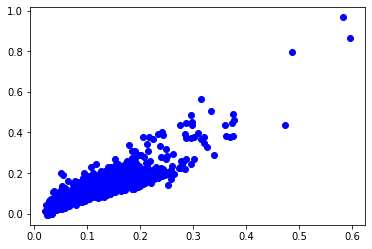

In [0]:
plt.plot(SMECO_dam_pred,trim_dataset(SMECO_dam_y_val, 24),"bo")

In [0]:
b = trim_dataset(SMECO_rt_x_val,24)

SMECO_rt_pred = rt_lstm_model.predict(b, batch_size= 24)

In [0]:
SMECO_rt_y_val.max()

1.3284372581979242

Text(0, 0.5, 'Real prices ($/MW)')

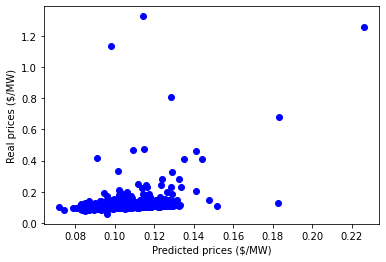

In [0]:
plt.plot(SMECO_rt_pred,trim_dataset(SMECO_rt_y_val, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")


## Retransform prices


In [0]:
def retransfor_MinMax(min, max, ytrans):
  y = (max-min)*ytrans + min
  return(y)

In [23]:
dam_max = scaler_dam.data_max_[9]
dam_min = scaler_dam.data_min_[9]

print(dam_max, dam_min)

164.34 11.14


In [24]:
rt_max = scaler_rt.data_max_[9]
rt_min = scaler_rt.data_min_[9]

print(rt_max, rt_min)

696.5 -53.08


In [0]:
SMECO_dam_pred_trans = retransfor_MinMax(dam_min,dam_max,SMECO_dam_pred)
SMECO_dam_y_val_trans = retransfor_MinMax(dam_min,dam_max,SMECO_dam_y_val)

Text(0, 0.5, 'Real prices ($/MW)')

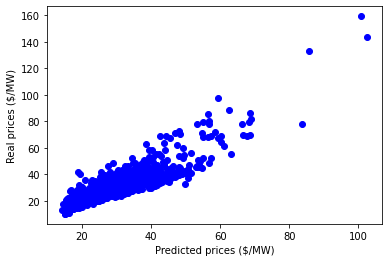

In [0]:
plt.plot(SMECO_dam_pred_trans,trim_dataset(SMECO_dam_y_val_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
SMECO_rt_pred_trans = retransfor_MinMax(rt_min,rt_max,SMECO_rt_pred)
SMECO_rt_y_val_trans = retransfor_MinMax(rt_min,rt_max,SMECO_rt_y_val)

Text(0, 0.5, 'Real prices ($/MW)')

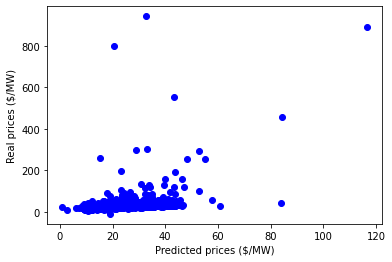

In [0]:
plt.plot(SMECO_rt_pred_trans,trim_dataset(SMECO_rt_y_val_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
dam_mse = mean_squared_error(trim_dataset(SMECO_dam_y_val_trans, 24),SMECO_dam_pred_trans)
rt_mse = mean_squared_error(trim_dataset(SMECO_rt_y_val_trans, 24),SMECO_rt_pred_trans)

print(dam_mse, rt_mse)


29.68407844896749 1839.973312567679


## Calculating MSE and MAE on test set

In [0]:
# Load models

from keras.models import load_model

model_DA = load_model("/content/drive/My Drive/Deep learning/SMECO_dam.h5")
model_RT = load_model("/content/drive/My Drive/Deep learning/SMECO_rt.h5")

In [0]:
# Trimming tests sets 

SMECO_dam_test_1 = trim_dataset(SMECO_dam_x_test_t,24)
SMECO_rt_test_1 = trim_dataset(SMECO_rt_x_test_t,24)

In [0]:
# Make predictions 

SMECO_dam_test_pred = model_DA.predict(SMECO_dam_test_1, batch_size=24)
SMECO_rt_test_pred = model_RT.predict(SMECO_rt_test_1, batch_size=24)

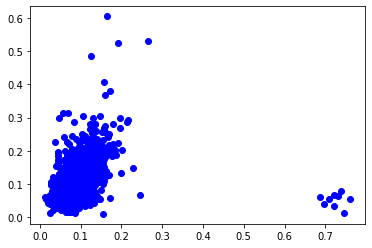

In [133]:
# Plotting real values vs predicted values 
plt.plot(SMECO_dam_test_pred,trim_dataset(SMECO_dam_y_test_t, 24),"bo")

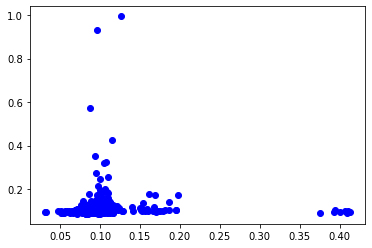

In [134]:
plt.plot(SMECO_rt_test_pred,trim_dataset(SMECO_rt_y_test_t, 24),"bo")

### Retransforming prices

In [0]:
def retransfor_MinMax(min, max, ytrans):
  y = (max-min)*ytrans + min
  return(y)

In [136]:
dam_max = scaler_dam.data_max_[9]
dam_min = scaler_dam.data_min_[9]

print(dam_max, dam_min)

281.07 11.09


In [137]:
rt_max = scaler_rt.data_max_[9]
rt_min = scaler_rt.data_min_[9]

print(rt_max, rt_min)

710.11 -53.56


In [0]:
SMECO_dam_pred_trans = retransfor_MinMax(dam_min,dam_max,SMECO_dam_test_pred)
SMECO_dam_real_trans = retransfor_MinMax(dam_min,dam_max,SMECO_dam_y_test_t)

Text(0, 0.5, 'Real prices ($/MW)')

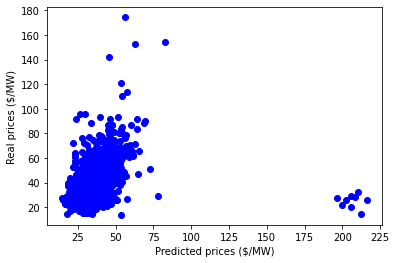

In [139]:
plt.plot(SMECO_dam_pred_trans,trim_dataset(SMECO_dam_real_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
SMECO_rt_pred_trans = retransfor_MinMax(rt_min,rt_max,SMECO_rt_test_pred)
SMECO_rt_real_trans = retransfor_MinMax(rt_min,rt_max,SMECO_rt_y_test_t)

Text(0, 0.5, 'Real prices ($/MW)')

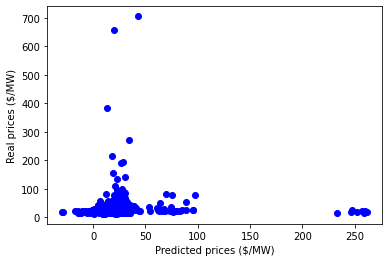

In [141]:
plt.plot(SMECO_rt_pred_trans,trim_dataset(SMECO_rt_real_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
SMECO_dam_pred = pd.DataFrame(SMECO_dam_pred_trans)
SMECO_dam_pred["Real"] = trim_dataset(SMECO_dam_real_trans, 24)
SMECO_dam_pred.to_csv("SMECO_dam_pred_trans.csv")

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [67]:
dam_mse = mean_squared_error(trim_dataset(SMECO_dam_real_trans, 24),SMECO_dam_pred_trans)
rt_mse = mean_squared_error(trim_dataset(SMECO_rt_real_trans, 24),SMECO_rt_pred_trans)

dam_mae = mean_absolute_error(trim_dataset(SMECO_dam_real_trans, 24),SMECO_dam_pred_trans)
rt_mae = mean_absolute_error(trim_dataset(SMECO_rt_real_trans, 24),SMECO_rt_pred_trans)

print(dam_mse, rt_mse, dam_mae, rt_mae)


118.81231365278354 1117.891709723671 5.823285902013867 10.939416389405276


# DOM_RESID_AGG

In [0]:
DOM_dam_train, DOM_dam_test, scaler_dam= Split_and_Norm(DOM_RESID_AGG_dam)
DOM_rt_train, DOM_rt_test, scaler_rt = Split_and_Norm(DOM_RESID_AGG_rt)

## DAM Model

### Building the input matrix


In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [73]:
DOM_dam_x, DOM_dam_y = build_timeseries(DOM_dam_train,9,25)

BATCH_SIZE = 24
DOM_dam_x = trim_dataset(DOM_dam_x, BATCH_SIZE)
DOM_dam_y = trim_dataset(DOM_dam_y, BATCH_SIZE)

length of time-series i/o (13471, 25, 10) (13471,)


In [74]:
x_temp, y_temp = build_timeseries(DOM_dam_test, 9,25)
BATCH_SIZE = 24
DOM_dam_x_val, DOM_dam_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
DOM_dam_y_val, DOM_dam_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3350, 25, 10) (3350,)


### Building model

In [0]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras import optimizers
from keras import callbacks

In [0]:
BATCH_SIZE = 24
TIME_STEPS = 25
lr = 0.001


In [0]:
dam_lstm_model = Sequential()
dam_lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, SMECO_dam_x.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,
                    kernel_initializer='random_uniform'))
#dam_lstm_model.add(Dropout(0.5))
#dam_lstm_model.add(Dense(20,activation='relu'))
dam_lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
dam_lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

In [0]:
dam_lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (24, 100)                 44400     
_________________________________________________________________
dense_11 (Dense)             (24, 1)                   101       
Total params: 44,501
Trainable params: 44,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)


dam_lstm_model.fit(DOM_dam_x, DOM_dam_y, epochs=30, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(DOM_dam_x_val, BATCH_SIZE),
                    trim_dataset(DOM_dam_y_val, BATCH_SIZE)), callbacks=[es])

Train on 13464 samples, validate on 1656 samples
Epoch 1/30
13464/13464 [==============================] - 12s 905us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/30
13464/13464 [==============================] - 11s 807us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.4314e-04 - val_mean_squared_error: 8.4314e-04
Epoch 3/30
13464/13464 [==============================] - 11s 807us/step - loss: 9.1010e-04 - mean_squared_error: 9.1010e-04 - val_loss: 7.8453e-04 - val_mean_squared_error: 7.8453e-04
Epoch 4/30
13464/13464 [==============================] - 11s 801us/step - loss: 7.6171e-04 - mean_squared_error: 7.6171e-04 - val_loss: 7.0528e-04 - val_mean_squared_error: 7.0528e-04
Epoch 5/30
13464/13464 [==============================] - 11s 819us/step - loss: 6.5200e-04 - mean_squared_error: 6.5200e-04 - val_loss: 7.0462e-04 - val_mean_squared_error: 7.0462e-04
Epoch 6/30
13464/13464 [==========================

In [0]:
dam_lstm_model.save("/content/drive/My Drive/Deep learning/DOM_dam.h5")

## RT Model

### Building the input matrix


In [75]:
DOM_rt_x, DOM_rt_y = build_timeseries(DOM_rt_train,9,3)

BATCH_SIZE = 24
DOM_rt_x = trim_dataset(DOM_rt_x, BATCH_SIZE)
DOM_rt_y = trim_dataset(DOM_rt_y, BATCH_SIZE)

length of time-series i/o (13493, 3, 10) (13493,)


In [76]:
x_temp, y_temp = build_timeseries(DOM_rt_test, 9,3)
BATCH_SIZE = 24
DOM_rt_x_val, DOM_rt_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
DOM_rt_y_val, DOM_rt_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3372, 3, 10) (3372,)


In [0]:
DOM_rt_y_val.max()

1.2128799088611573

### Building model

In [0]:
BATCH_SIZE = 24
TIME_STEPS = 3
lr = 0.001


In [0]:
rt_lstm_model = Sequential()
rt_lstm_model.add(LSTM(90, batch_input_shape=(BATCH_SIZE, TIME_STEPS, SMECO_dam_x.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,
                    kernel_initializer='random_uniform'))
#rt_lstm_model.add(Dropout(0.5))
#rt_lstm_model.add(Dense(20,activation='relu'))
rt_lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
rt_lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)


rt_lstm_model.fit(DOM_rt_x, DOM_rt_y, epochs=30, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(DOM_rt_x_val, BATCH_SIZE),
                    trim_dataset(DOM_rt_y_val, BATCH_SIZE)), callbacks=[es])

Train on 13488 samples, validate on 1680 samples
Epoch 1/30
13488/13488 [==============================] - 4s 276us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2/30
13488/13488 [==============================] - 2s 169us/step - loss: 6.7586e-04 - mean_squared_error: 6.7586e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 3/30
13488/13488 [==============================] - 2s 165us/step - loss: 6.4977e-04 - mean_squared_error: 6.4977e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 4/30
13488/13488 [==============================] - 2s 166us/step - loss: 6.3582e-04 - mean_squared_error: 6.3582e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/30
13488/13488 [==============================] - 2s 164us/step - loss: 6.2709e-04 - mean_squared_error: 6.2709e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 6/30
13488/13488 [==============================] - 2s 164us/step - loss:

In [0]:
rt_lstm_model.save("/content/drive/My Drive/Deep learning/DOM_rt.h5")

### Making predictions on validation data

In [0]:
a = trim_dataset(DOM_dam_x_val, 24)

DOM_dam_pred = dam_lstm_model.predict(a, batch_size= 24)

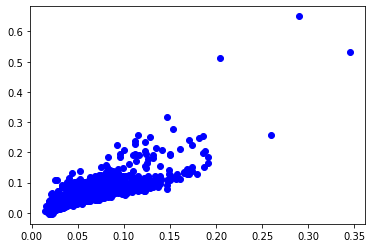

In [0]:
plt.plot(DOM_dam_pred,trim_dataset(DOM_dam_y_val, 24),"bo")

In [0]:
b = trim_dataset(DOM_rt_x_val,24)

DOM_rt_pred = rt_lstm_model.predict(b, batch_size= 24)

In [0]:
DOM_rt_y_val.max()

1.2128799088611573

Text(0, 0.5, 'Real prices ($/MW)')

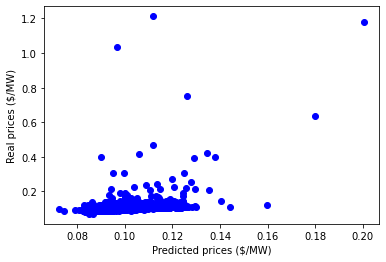

In [0]:
plt.plot(DOM_rt_pred,trim_dataset(DOM_rt_y_val, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")


## Retransform prices


In [0]:
def retransfor_MinMax(min, max, ytrans):
  y = (max-min)*ytrans + min
  return(y)

In [0]:
dam_max = scaler_dam.data_max_[9]
dam_min = scaler_dam.data_min_[9]

print(dam_max, dam_min)

164.34 11.14


In [0]:
rt_max = scaler_rt.data_max_[9]
rt_min = scaler_rt.data_min_[9]

print(rt_max, rt_min)

696.5 -53.08


In [0]:
DOM_dam_pred_trans = retransfor_MinMax(dam_min,dam_max,DOM_dam_pred)
DOM_dam_y_val_trans = retransfor_MinMax(dam_min,dam_max,DOM_dam_y_val)

Text(0, 0.5, 'Real prices ($/MW)')

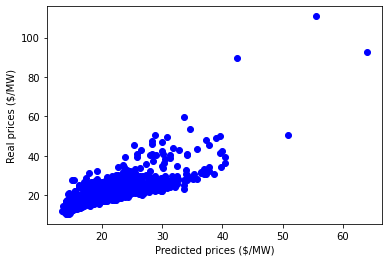

In [0]:
plt.plot(DOM_dam_pred_trans,trim_dataset(DOM_dam_y_val_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
DOM_rt_pred_trans = retransfor_MinMax(rt_min,rt_max,DOM_rt_pred)
DOM_rt_y_val_trans = retransfor_MinMax(rt_min,rt_max,DOM_rt_y_val)

Text(0, 0.5, 'Real prices ($/MW)')

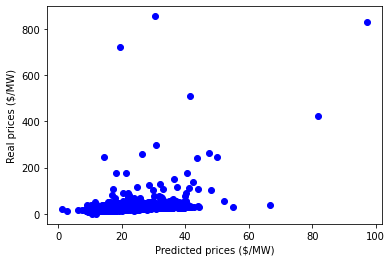

In [0]:
plt.plot(DOM_rt_pred_trans,trim_dataset(DOM_rt_y_val_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
dam_mse = mean_squared_error(trim_dataset(DOM_dam_y_val_trans, 24),DOM_dam_pred_trans)
rt_mse = mean_squared_error(trim_dataset(DOM_rt_y_val_trans, 24),DOM_rt_pred_trans)

print(dam_mse, rt_mse)


15.392117568215323 1585.4512931405627


## Calculating MSE and MAE on test set

In [0]:
# Load models

from keras.models import load_model

model_DA = load_model("/content/drive/My Drive/Deep learning/DOM_dam.h5")
model_RT = load_model("/content/drive/My Drive/Deep learning/DOM_rt.h5")

In [0]:
# Trimming tests sets 

DOM_dam_test_1 = trim_dataset(DOM_dam_x_test_t,24)
DOM_rt_test_1 = trim_dataset(DOM_rt_x_test_t,24)

In [0]:
# Make predictions 

DOM_dam_test_pred = model_DA.predict(DOM_dam_test_1, batch_size=24)
DOM_rt_test_pred = model_RT.predict(DOM_rt_test_1, batch_size=24)

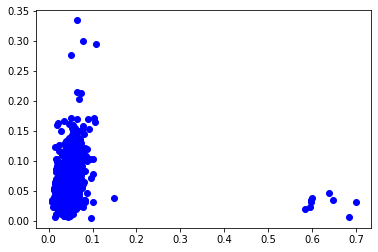

In [80]:
# Plotting real values vs predicted values 
plt.plot(DOM_dam_test_pred,trim_dataset(DOM_dam_y_test_t, 24),"bo")

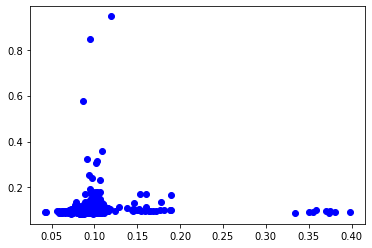

In [81]:
plt.plot(DOM_rt_test_pred,trim_dataset(DOM_rt_y_test_t, 24),"bo")

### Retransforming prices

In [0]:
def retransfor_MinMax(min, max, ytrans):
  y = (max-min)*ytrans + min
  return(y)

In [83]:
dam_max = scaler_dam.data_max_[9]
dam_min = scaler_dam.data_min_[9]

print(dam_max, dam_min)

281.07 11.09


In [84]:
rt_max = scaler_rt.data_max_[9]
rt_min = scaler_rt.data_min_[9]

print(rt_max, rt_min)

710.11 -53.56


In [0]:
DOM_dam_pred_trans = retransfor_MinMax(dam_min,dam_max,DOM_dam_test_pred)
DOM_dam_real_trans = retransfor_MinMax(dam_min,dam_max,DOM_dam_y_test_t)

Text(0.5, 0, 'Real prices ($/MW)')

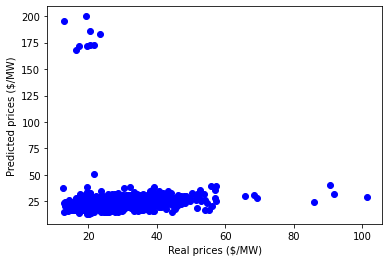

In [89]:
plt.plot(trim_dataset(DOM_dam_real_trans, 24),DOM_dam_pred_trans,"bo")
plt.ylabel("Predicted prices ($/MW)")
plt.xlabel("Real prices ($/MW)")

In [0]:
DOM_dam_pred = pd.DataFrame(DOM_dam_pred_trans)
DOM_dam_pred["Real"] = trim_dataset(DOM_dam_real_trans, 24)
DOM_dam_pred.to_csv("DOM_dam_pred_trans.csv")

In [0]:
DOM_rt_pred_trans = retransfor_MinMax(rt_min,rt_max,DOM_rt_test_pred)
DOM_rt_real_trans = retransfor_MinMax(rt_min,rt_max,DOM_rt_y_test_t)

Text(0, 0.5, 'Real prices ($/MW)')

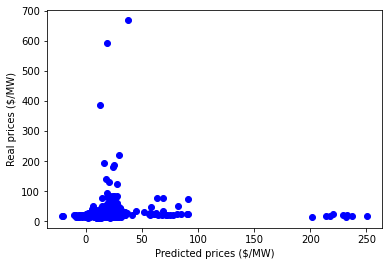

In [96]:
plt.plot(DOM_rt_pred_trans,trim_dataset(DOM_rt_real_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [98]:
dam_mse = mean_squared_error(trim_dataset(DOM_dam_real_trans, 24),DOM_dam_pred_trans)
rt_mse = mean_squared_error(trim_dataset(DOM_rt_real_trans, 24),DOM_rt_pred_trans)

dam_mae = mean_absolute_error(trim_dataset(DOM_dam_real_trans, 24),DOM_dam_pred_trans)
rt_mae = mean_absolute_error(trim_dataset(DOM_rt_real_trans, 24),DOM_rt_pred_trans)

print(dam_mse, rt_mse, dam_mae, rt_mae)


218.8870325215423 983.2758160956967 6.859307691588295 10.36733176386252


# AEPKY_RESID_AGG

In [0]:
AEPKY_dam_train, AEPKY_dam_test, dam_scaler = Split_and_Norm(AEPKY_RESID_AGG_dam)
AEPKY_rt_train, AEPKY_rt_test, rt_scaler = Split_and_Norm(AEPKY_RESID_AGG_rt)

## DAM Model

### Building the input matrix


In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [102]:
AEPKY_dam_x, AEPKY_dam_y = build_timeseries(AEPKY_dam_train,9,25)

BATCH_SIZE = 24
AEPKY_dam_x = trim_dataset(AEPKY_dam_x, BATCH_SIZE)
AEPKY_dam_y = trim_dataset(AEPKY_dam_y, BATCH_SIZE)

length of time-series i/o (13471, 25, 10) (13471,)


In [103]:
x_temp, y_temp = build_timeseries(AEPKY_dam_test, 9,25)
BATCH_SIZE = 24
AEPKY_dam_x_val, AEPKY_dam_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
AEPKY_dam_y_val, AEPKY_dam_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3350, 25, 10) (3350,)


### Building model

In [0]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras import optimizers
from keras import callbacks

In [0]:
BATCH_SIZE = 24
TIME_STEPS = 25
lr = 0.001


In [0]:
dam_lstm_model = Sequential()
dam_lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, SMECO_dam_x.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,
                    kernel_initializer='random_uniform'))
#dam_lstm_model.add(Dropout(0.5))
#dam_lstm_model.add(Dense(20,activation='relu'))
dam_lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
dam_lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

In [0]:
dam_lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (24, 100)                 44400     
_________________________________________________________________
dense_13 (Dense)             (24, 1)                   101       
Total params: 44,501
Trainable params: 44,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)


dam_lstm_model.fit(AEPKY_dam_x, AEPKY_dam_y, epochs=30, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(AEPKY_dam_x_val, BATCH_SIZE),
                    trim_dataset(AEPKY_dam_y_val, BATCH_SIZE)), callbacks=[es])

Train on 13464 samples, validate on 1656 samples
Epoch 1/30
13464/13464 [==============================] - 13s 946us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2/30
13464/13464 [==============================] - 11s 816us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/30
13464/13464 [==============================] - 11s 830us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/30
13464/13464 [==============================] - 11s 831us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/30
13464/13464 [==============================] - 11s 823us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/30
13464/13464 [==============================] - 11s 819us/step - loss: 9.1912e-04 - mean_squared

In [0]:
dam_lstm_model.save("/content/drive/My Drive/Deep learning/AEPKY_dam.h5")

## RT Model

### Building the input matrix


In [104]:
AEPKY_rt_x, AEPKY_rt_y = build_timeseries(AEPKY_rt_train,9,3)

BATCH_SIZE = 24
AEPKY_rt_x = trim_dataset(AEPKY_rt_x, BATCH_SIZE)
AEPKY_rt_y = trim_dataset(AEPKY_rt_y, BATCH_SIZE)

length of time-series i/o (13493, 3, 10) (13493,)


In [105]:
x_temp, y_temp = build_timeseries(AEPKY_rt_test, 9,3)
BATCH_SIZE = 24
AEPKY_rt_x_val, AEPKY_rt_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
AEPKY_rt_y_val, AEPKY_rt_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3372, 3, 10) (3372,)


In [106]:
AEPKY_rt_y_val.max()

1.2021614480858955

### Building model

In [0]:
BATCH_SIZE = 24
TIME_STEPS = 3
lr = 0.001


In [0]:
rt_lstm_model = Sequential()
rt_lstm_model.add(LSTM(90, batch_input_shape=(BATCH_SIZE, TIME_STEPS, SMECO_dam_x.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,
                    kernel_initializer='random_uniform'))
#rt_lstm_model.add(Dropout(0.5))
#rt_lstm_model.add(Dense(20,activation='relu'))
rt_lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
rt_lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)


rt_lstm_model.fit(AEPKY_rt_x, AEPKY_rt_y, epochs=30, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(AEPKY_rt_x_val, BATCH_SIZE),
                    trim_dataset(AEPKY_rt_y_val, BATCH_SIZE)), callbacks=[es])

Train on 13488 samples, validate on 1680 samples
Epoch 1/30
13488/13488 [==============================] - 4s 311us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/30
13488/13488 [==============================] - 2s 173us/step - loss: 6.0701e-04 - mean_squared_error: 6.0701e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 3/30
13488/13488 [==============================] - 2s 176us/step - loss: 5.7979e-04 - mean_squared_error: 5.7979e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 4/30
13488/13488 [==============================] - 2s 178us/step - loss: 5.6658e-04 - mean_squared_error: 5.6658e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 5/30
13488/13488 [==============================] - 2s 178us/step - loss: 5.5951e-04 - mean_squared_error: 5.5951e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/30
13488/13488 [==============================] - 2s 176us/step - loss:

In [0]:
rt_lstm_model.save("/content/drive/My Drive/Deep learning/AEPKY_rt.h5")

### Making predictions on validation data

In [0]:
a = trim_dataset(AEPKY_dam_x_val, 24)

AEPKY_dam_pred = dam_lstm_model.predict(a, batch_size= 24)

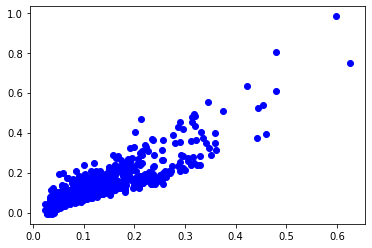

In [0]:
plt.plot(AEPKY_dam_pred,trim_dataset(AEPKY_dam_y_val, 24),"bo")

In [0]:
b = trim_dataset(AEPKY_rt_x_val,24)

AEPKY_rt_pred = rt_lstm_model.predict(b, batch_size= 24)

In [0]:
AEPKY_rt_y_val.max()

1.2021614480858955

Text(0, 0.5, 'Real prices ($/MW)')

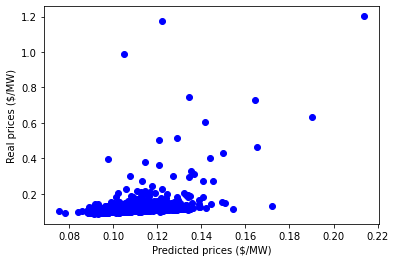

In [0]:
plt.plot(AEPKY_rt_pred,trim_dataset(AEPKY_rt_y_val, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")


## Retransform prices


In [0]:
def retransfor_MinMax(min, max, ytrans):
  y = (max-min)*ytrans + min
  return(y)

In [0]:
dam_max = scaler_dam.data_max_[9]
dam_min = scaler_dam.data_min_[9]

print(dam_max, dam_min)

164.34 11.14


In [0]:
rt_max = scaler_rt.data_max_[9]
rt_min = scaler_rt.data_min_[9]

print(rt_max, rt_min)

696.5 -53.08


In [0]:
AEPKY_dam_pred_trans = retransfor_MinMax(dam_min,dam_max,AEPKY_dam_pred)
AEPKY_dam_y_val_trans = retransfor_MinMax(dam_min,dam_max,AEPKY_dam_y_val)

Text(0, 0.5, 'Real prices ($/MW)')

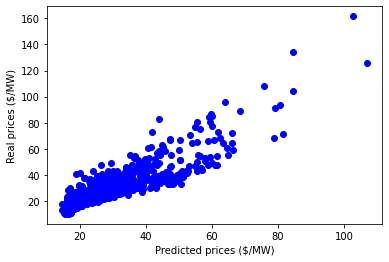

In [0]:
plt.plot(AEPKY_dam_pred_trans,trim_dataset(AEPKY_dam_y_val_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
AEPKY_rt_pred_trans = retransfor_MinMax(rt_min,rt_max,AEPKY_rt_pred)
AEPKY_rt_y_val_trans = retransfor_MinMax(rt_min,rt_max,AEPKY_rt_y_val)

Text(0, 0.5, 'Real prices ($/MW)')

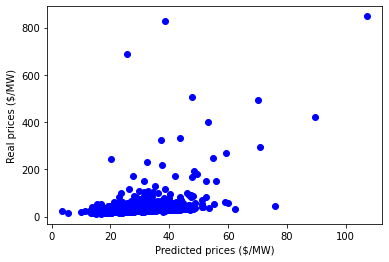

In [0]:
plt.plot(AEPKY_rt_pred_trans,trim_dataset(AEPKY_rt_y_val_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
dam_mse = mean_squared_error(trim_dataset(AEPKY_dam_y_val_trans, 24),AEPKY_dam_pred_trans)
rt_mse = mean_squared_error(trim_dataset(AEPKY_rt_y_val_trans, 24),AEPKY

_rt_pred_trans)

print(dam_mse, rt_mse)


31.961611465630064 1782.2159155234015


## Calculating MSE and MAE on test set

In [0]:
# Load models

from keras.models import load_model

model_DA = load_model("/content/drive/My Drive/Deep learning/AEPKY_dam.h5")
model_RT = load_model("/content/drive/My Drive/Deep learning/AEPKY_rt.h5")

In [0]:
# Trimming tests sets 

AEPKY_dam_test_1 = trim_dataset(AEPKY_dam_x_test_t,24)
AEPKY_rt_test_1 = trim_dataset(AEPKY_rt_x_test_t,24)

In [0]:
# Make predictions 

AEPKY_dam_test_pred = model_DA.predict(AEPKY_dam_test_1, batch_size=24)
AEPKY_rt_test_pred = model_RT.predict(AEPKY_rt_test_1, batch_size=24)

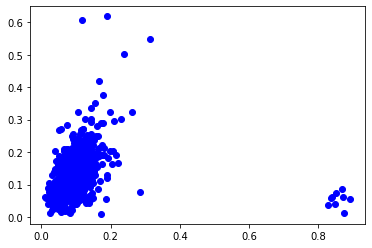

In [110]:
# Plotting real values vs predicted values 
plt.plot(AEPKY_dam_test_pred,trim_dataset(AEPKY_dam_y_test_t, 24),"bo")

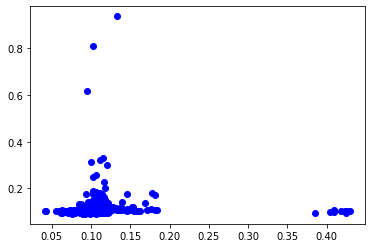

In [111]:
plt.plot(AEPKY_rt_test_pred,trim_dataset(AEPKY_rt_y_test_t, 24),"bo")

### Retransforming prices

In [0]:
def retransfor_MinMax(min, max, ytrans):
  y = (max-min)*ytrans + min
  return(y)

In [113]:
dam_max = scaler_dam.data_max_[9]
dam_min = scaler_dam.data_min_[9]

print(dam_max, dam_min)

281.07 11.09


In [114]:
rt_max = scaler_rt.data_max_[9]
rt_min = scaler_rt.data_min_[9]

print(rt_max, rt_min)

710.11 -53.56


In [0]:
AEPKY_dam_pred_trans = retransfor_MinMax(dam_min,dam_max,AEPKY_dam_test_pred)
AEPKY_dam_real_trans = retransfor_MinMax(dam_min,dam_max,AEPKY_dam_y_test_t)

Text(0.5, 0, 'Real prices ($/MW)')

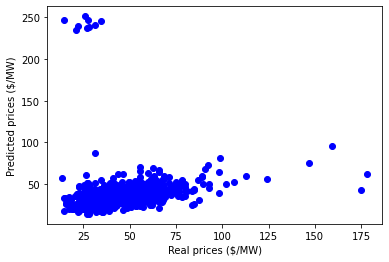

In [116]:
plt.plot(trim_dataset(AEPKY_dam_real_trans, 24),AEPKY_dam_pred_trans,"bo")
plt.ylabel("Predicted prices ($/MW)")
plt.xlabel("Real prices ($/MW)")

In [0]:
AEPKY_dam_pred = pd.DataFrame(AEPKY_dam_pred_trans)
AEPKY_dam_pred["Real"] = trim_dataset(AEPKY_dam_real_trans, 24)
AEPKY_dam_pred.to_csv("AEPKY_dam_pred_trans.csv")

In [0]:
AEPKY_rt_pred_trans = retransfor_MinMax(rt_min,rt_max,AEPKY_rt_test_pred)
AEPKY_rt_real_trans = retransfor_MinMax(rt_min,rt_max,AEPKY_rt_y_test_t)

Text(0, 0.5, 'Real prices ($/MW)')

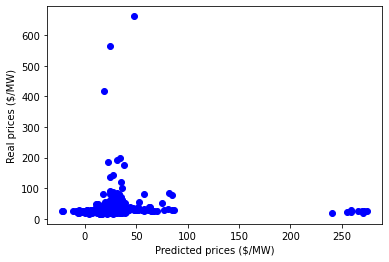

In [119]:
plt.plot(AEPKY_rt_pred_trans,trim_dataset(AEPKY_rt_real_trans, 24),"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [121]:
dam_mse = mean_squared_error(trim_dataset(AEPKY_dam_real_trans, 24),AEPKY_dam_pred_trans)
rt_mse = mean_squared_error(trim_dataset(AEPKY_rt_real_trans, 24),AEPKY_rt_pred_trans)

dam_mae = mean_absolute_error(trim_dataset(AEPKY_dam_real_trans, 24),AEPKY_dam_pred_trans)
rt_mae = mean_absolute_error(trim_dataset(AEPKY_rt_real_trans, 24),AEPKY_rt_pred_trans)

print(dam_mse, rt_mse, dam_mae, rt_mae)


436.1176071397942 1001.1367817093676 10.257004629722719 10.098429488972878
